# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-10-30</font>

In [1]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [2]:
# Leave this code as-is

FILENAME_MOVIES = "ml32m-movies-2000s.csv.gz"
FILENAME_RATINGS = "ml32m-ratings-2000s.csv.gz"
FILENAME_TAGS = "ml32m-tags-2000s.csv.gz"

In [3]:
# LEAVE THIS CODE AS-IS

# Load movies
movies = pd.read_csv(FILENAME_MOVIES, 
                    compression='gzip',
                    sep=',', 
                    engine='python', 
                    encoding='utf-8',
                    names=['movie_id', 'title', 'genres'])

# Remove header row from this file
movies.drop(index=0, inplace=True)

# Make sure the movie id is numeric
movies["movie_id"] = pd.to_numeric(movies["movie_id"])
display(movies.head(5))

,movie_id,title,genres
1,2769,"Yards, The (2000)",Crime|Drama
2,3177,Next Friday (2000),Comedy
3,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
4,3225,Down to You (2000),Comedy|Romance
5,3228,Wirey Spindell (2000),Comedy


In [4]:
# LEAVE THIS CODE AS-IS

# Load ratings
ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    compression='gzip',
                    encoding='utf-8',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,user_id,movie_id,rating
0,4,223,4.0
1,4,1210,3.0
2,4,1272,4.0
3,4,1327,3.0
4,4,1513,2.0


<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [5]:
def yearof(text):
    match = re.search(r"\((\d{4})\)", text)
    if match:
        return int(match.group(1))
    else:
        return None

movies['year'] = movies['title'].apply(yearof)
display(movies.tail(5))

,movie_id,title,genres,year
51440,292709,End of the Season (2017),Drama,2017
51441,292731,The Monroy Affaire (2022),Drama,2022
51442,292737,Shelter in Solitude (2023),Comedy|Drama,2023
51443,292753,Orca (2023),Drama,2023
51444,292757,Race to the Summit (2023),Action|Adventure|Documentary,2023


<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and movies.</font>

## Answer
We can join ratings_raw and movies on movie_id since it is the common column these two dataframes share.

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genders, year</font>

In [6]:
df_ratings_movies = pd.merge(movies, ratings_raw, how='inner', on='movie_id')
display(df_ratings_movies.head(10))

,movie_id,title,genres,year,user_id,rating
0,2769,"Yards, The (2000)",Crime|Drama,2000,365,4.0
1,2769,"Yards, The (2000)",Crime|Drama,2000,6965,1.0
2,2769,"Yards, The (2000)",Crime|Drama,2000,12489,4.0
3,2769,"Yards, The (2000)",Crime|Drama,2000,13946,4.0
4,2769,"Yards, The (2000)",Crime|Drama,2000,22141,2.0
5,2769,"Yards, The (2000)",Crime|Drama,2000,24216,1.5
6,2769,"Yards, The (2000)",Crime|Drama,2000,25384,3.0
7,2769,"Yards, The (2000)",Crime|Drama,2000,26651,3.0
8,2769,"Yards, The (2000)",Crime|Drama,2000,27418,3.0
9,2769,"Yards, The (2000)",Crime|Drama,2000,30157,4.0


<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [7]:
def find_movies(keyword, df):
    for _, row in df.iterrows():
        if keyword.lower() in row['title'].lower():
            print(f"movie_id: {row['movie_id']}, title: {row['title']}")
            
find_movies("Barcelona", movies)


movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)
movie_id: 213736, title: Barcelona Summer Night (2013)
movie_id: 259761, title: The Barcelona Vampiress (2020)
movie_id: 288765, title: Bird Box Barcelona (2023)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [8]:
# LEAVE AS-IS

ratings_raw['rating'].describe()

count    2.671536e+06
mean     3.556416e+00
std      1.056151e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

Text(0, 0.5, 'Probability')

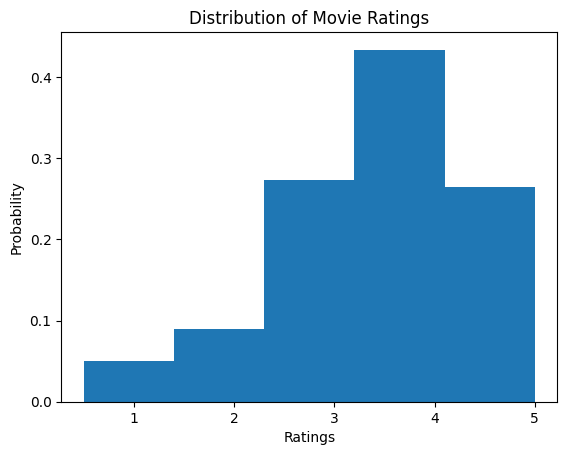

In [9]:
plt.figure()
plt.hist(ratings_raw['rating'], bins=5, density=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Probability")

<font size="+1" color="red">Replace this cell with your code to plot a boxplot of ratings. Look for outlier values. </font>

{'whiskers': [<matplotlib.lines.Line2D at 0x2339168d450>,
 'caps': [<matplotlib.lines.Line2D at 0x2339168d6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2339168d310>],
 'medians': [<matplotlib.lines.Line2D at 0x2339168d950>],
 'fliers': [<matplotlib.lines.Line2D at 0x2339168da90>],
 'means': []}

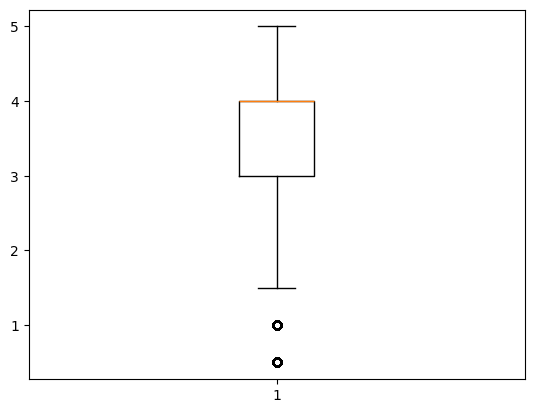

In [10]:
plt.boxplot(ratings_raw['rating'], vert=True)

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

## Answer
From both histogram and boxplot we can observe that the most common ratings the movies have range from 3 to 5, and rating from 1 to 2 is very rare cases.


<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are equal to 5.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are equal to 1.0)</font>

In [11]:
movies_best = df_ratings_movies[df_ratings_movies['rating'] == 5.0]['title'].value_counts().nlargest(10)
print("\n======================10 best 5-star rating movies======================")
print(movies_best.head(10))
movies_worst = df_ratings_movies[df_ratings_movies['rating'] == 1.0]['title'].value_counts().nlargest(10)
print("\n======================10 worst 1-star rating movies======================")
print(movies_worst.head(10))



======================10 best 5-star rating movies======================
title
Lord of the Rings: The Fellowship of the Ring, The (2001)    2677
Lord of the Rings: The Return of the King, The (2003)        2468
Lord of the Rings: The Two Towers, The (2002)                2304
Memento (2000)                                               1560
Gladiator (2000)                                             1442
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1376
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         1297
Eternal Sunshine of the Spotless Mind (2004)                 1213
Kill Bill: Vol. 1 (2003)                                      997
Shrek (2001)                                                  932
Name: count, dtype: int64

======================10 worst 1-star rating movies======================
title
Star Wars: Episode II - Attack of the Clones (2002)          178
Battlefield Earth (2000)                                     175
Charlie's Angels (2000)

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

## Answer
Best 5-star movies: Most of the top-rated films are critically acclaimed classics, such as The Lord of the Rings trilogy, Memento, Gladiator, and Spirited Away. These films are well-known for strong storytelling, direction, and visual effects, which likely explains the high number of 5-star ratings.

Worst 1-star movies: Conversely, the bottom-rated films include commercially released blockbusters that were widely criticized, such as Star Wars: Episode II, Battlefield Earth, and Pearl Harbor. Many of these movies received poor reviews for plot, acting, or special effects. Interestingly, some films like The Lord of the Rings also appear here, showing that even highly acclaimed movies can receive a small number of 1-star ratings from a minority of users.

Observation: This highlights that while aggregate ratings often align with critical and popular reception, individual preferences vary, leading to some overlap. Popular films tend to accumulate both very high and very low ratings simply due to their large audience.

In short, highly praised films dominate the top list, while poorly reviewed or divisive films dominate the bottom list, but audience size and diversity can cause some crossover.


## 2.2. Genres distribution

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 20 genres with an assert, as follows:
    assert(n == 20).</font>

In [12]:
# genres
all_genres_flat = [g for sublist in movies['genres'].str.split('|') for g in sublist]
genre_labels = pd.DataFrame({'genre': list(set(all_genres_flat))})
assert(len(genre_labels) == 20)
display(genre_labels)

,genre
0,Sci-Fi
1,Documentary
2,Crime
3,(no genres listed)
4,Adventure
5,Drama
6,Musical
7,Children
8,Horror
9,Animation


<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre in the dataset, check that it returns the same result as above. Create a function `calc_genre_count_avg_rating()` that receives all relevant arguments, i.e, is invoked as `calc_genre_count_avg_rating(movies, 'genres', genre_labels, ratings)` and returns a dataframe with *genre, count, avg_rating* columns. Feel free to use auxiliary functions.</font>

In [13]:
# def calc_genre_count_avg_rating(df, feature, labels, ratings):
#     rating_sum = {}
#     count = {}
#     avg_rating = {}
#     for label in labels:
#         count[label] = 0
#         rating_sum[label] = 0
#         for _, row in df.iterrows():
#             movie_genres = str(row[feature]).split('|')
#             if label in movie_genres:
#                 rating_sum[label] += row[ratings]
#                 count[label] += 1
#         avg_rating[label] = rating_sum[label] / count[label] if count[label] > 0 else 0
#     movies_rating_stats = pd.DataFrame({'genre':labels, 
#                                         'count': [count[l] for l in labels],
#                                         'avg_rating': [round(avg_rating[l], 2) for l in labels]})
#     movies_rating_stats = movies_rating_stats.sort_values(by='count', ascending=False).reset_index(drop=True)
#     return movies_rating_stats

In [ ]:
# I am not sure if 'ratings' refer to the feature name or an array so I use it as the rating dataframe
def calc_genre_count_avg_rating(movies, feature, labels, ratings):

    # Merge movies and ratings
    df = pd.merge(movies, ratings, on='movie_id', how='inner')

    # Explode genres
    df['genre'] = df[feature].str.split('|')
    df_exploded = df.explode('genre')

    # group by genre
    genre_stats = (
        df_exploded.groupby('genre')['rating']
        .agg(count='count', avg_rating='mean')
        .reset_index()
    )

    # round and sort
    genre_stats['avg_rating'] = genre_stats['avg_rating'].round(2)
    genre_stats = genre_stats.sort_values(by='count', ascending=False).reset_index(drop=True)

    return genre_stats


In [15]:
# LEAVE THIS CODE AS-IS

genre_count_avg_rating = calc_genre_count_avg_rating(movies, 'genres', genre_labels['genre'], ratings_raw)
genre_count_avg_rating

,genre,count,avg_rating
0,Drama,318210,3.63
1,Comedy,256395,3.35
2,Action,230782,3.43
3,Thriller,224786,3.51
4,Adventure,206969,3.54
5,Romance,137872,3.51
6,Crime,126516,3.60
7,Sci-Fi,112165,3.40
8,Fantasy,110898,3.61
9,Mystery,73589,3.64


<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the previous table, particularly what are the genres with the best/worst ratings, and why do you believe that happens.</font>

## Answer
Looking at the table, Film-Noir, Mystery, Fantasy, Crime, and Documentary have the highest average ratings, with Film-Noir at 3.79 being the top. Conversely, Horror and Western have the lowest average ratings, at 3.16 and 3.29 respectively. This pattern suggests that audiences tend to rate niche or specialized genres more favorably, while genres like Horror and Western are more polarizing or less universally appealing.

<font size="+1" color="red">Replace this cell with code to produce two bar plots: one for movies filmed on 2010 or before, and another for movies filmed on 2020 or later.</font>

C:\Users\zsy\AppData\Local\Temp\ipykernel_4692\3575403959.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


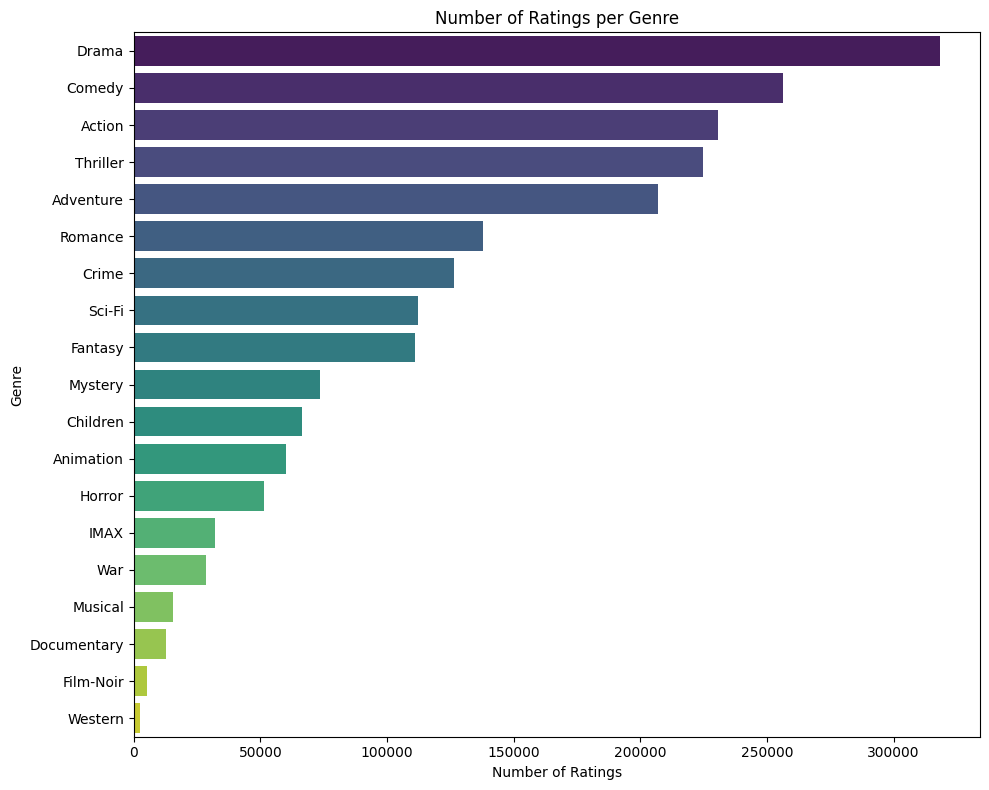

In [16]:
# Sort genres from most common to least common
genre_plot_data = genre_count_avg_rating.sort_values(by='count', ascending=False)

# Create horizontal barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x='count', 
    y='genre', 
    data=genre_plot_data, 
    orient='h',  # horizontal bars
    palette='viridis'
)

# Set title and axis labels
ax.set(
    title='Number of Ratings per Genre',
    xlabel='Number of Ratings',
    ylabel='Genre'
)

plt.tight_layout()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary comparing both distributions, including which genres changed popularity.</font>

## Answer
The genres with the highest average ratings are Film-Noir (3.79), Mystery (3.64), Fantasy (3.61), Crime (3.60), and Documentary (3.60), while the lowest rated genres are Horror (3.16), Western (3.29), Comedy (3.35), and Sci-Fi (3.40). Notably, some popular genres like Comedy and Action are moderate in ratings despite high counts, whereas niche genres like Film-Noir and Mystery receive the highest ratings despite having few movies. This shows that less frequent genres are often more appreciated by their audiences, while mainstream genres attract more viewers but do not always achieve top ratings.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

In [17]:
# Replace NaN with empty string and ensure it is a string type
movies['genres'] = movies['genres'].fillna('').astype(str)

# Split the genres by "|" to create a list
movies['genres_arr'] = movies['genres'].str.split('|')
display(movies.head())

,movie_id,title,genres,year,genres_arr
1,2769,"Yards, The (2000)",Crime|Drama,2000,"[Crime, Drama]"
2,3177,Next Friday (2000),Comedy,2000,[Comedy]
3,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000,"[Adventure, Sci-Fi, Thriller]"
4,3225,Down to You (2000),Comedy|Romance,2000,"[Comedy, Romance]"
5,3228,Wirey Spindell (2000),Comedy,2000,[Comedy]


In [18]:
# LEAVE THIS CODE AS-IS

print("Transformed: %s → %s" % (movies['genres'][4], movies['genres_arr'][4]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [19]:
# LEAVE THIS CODE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2020]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,34111,209311,Waves (2020),Drama|Romance,2020,"[Drama, Romance]"
1,34403,210455,Gretel & Hansel (2020),Fantasy|Horror|Thriller,2020,"[Fantasy, Horror, Thriller]"
2,34409,210469,Like a Boss (2020),Comedy,2020,[Comedy]
3,34431,210569,Birds of Prey (And the Fantabulous Emancipatio...,Action|Adventure|Crime,2020,"[Action, Adventure, Crime]"
4,34432,210571,Fantasy Island (2020),Fantasy|Horror|Sci-Fi,2020,"[Fantasy, Horror, Sci-Fi]"


<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

In [20]:
# Convert the list of genres into a single string per movie
movies_filtered['genres_text'] = movies_filtered['genres_arr'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF vectorizer with 1-grams and 2-grams
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Fit and transform the genres text into TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres_text'])

# Verify the shape
print(tfidf_matrix.shape)
# print(tfidf_matrix)

(7986, 128)


## 3.2. Calculate most similar movies

In [21]:
# LEAVE THIS CODE AS-IS

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         0.         ... 0.15629465 0.37012241 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.48040741 0.         0.        ]
 ...
 [0.15629465 0.         0.48040741 ... 1.         0.42227826 0.        ]
 [0.37012241 0.         0.         ... 0.42227826 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [22]:
# LEAVE THIS CODE AS-IS

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))

# Test with the movie: "Gretel & Hansel (2020)"
print_similarity_vector(210455, cosine_sim)

0.000 209311 Waves (2020)
1.000 210455 Gretel & Hansel (2020)
0.000 210469 Like a Boss (2020)
0.000 210569 Birds of Prey (And the Fantabulous Emancipation of One Harley Quinn) (2020)
0.556 210571 Fantasy Island (2020)
0.000 210573 The King's Man (2020)
0.000 210575 The Photograph (2020)
0.108 210577 Sonic the Hedgehog (2020)
0.000 210579 What About Love (2020)
0.132 210847 Bloodshot (2020)
0.000 210849 The Call of the Wild (2020)
0.000 210851 Emma (2020)
0.000 210853 My Boyfriend's Meds (2020)
0.075 210855 The Rhythm Section (2020)
0.641 210857 The Turning (2020)
0.296 210859 Run (2020)
0.000 210861 The Gentlemen (2020)
0.187 210863 Dolittle (2020)
0.089 210865 Bad Boys for Life (2020)
0.131 210867 Underwater (2020)
0.000 210869 My Spy (2020)
0.000 210873 Invasion (2020)
0.000 211141 Echo (2020)
0.137 211223 The Grudge (2020)
0.000 211391 Downhill (2020)
0.000 211428 Ana (2020)
0.000 211504 Rogue Warfare: Death of a Nation (2020)
0.000 211540 Tolo Tolo (2020)
0.153 211544 De kuthoer (2

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [23]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    # Get similarity scores for this movie
    sim_scores = similarities[index_source]
    
    enumerated = list(enumerate(sim_scores))
    enumerated = [(i, s) for i, s in enumerated if i != index_source]
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]
    
    # for index, similarity in top_similarities:
    #     print("Element #%d with similarity %.1f" % (index, similarity))
        
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain recom_movie_id, title, genres
        rec_movie_id = movies.iloc[index_target]['movie_id']
        title = movies.iloc[index_target].title
        genres = movies.iloc[index_target].genres
        recommendations.append({
                'movie_id': movie_id,           # Original movie
                'recom_movie_id': rec_movie_id, # Movie that is recommended
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations,
                                     columns=['movie_id', 'recom_movie_id', 'similarity', 'title', 'genres'])

<font size="+1" color="red">Replace this cell with code to print the top 10 recommendations for movie "Oxygen (2021)" and "PAW Patrol: The Movie (2021)".</font>

In [24]:
movie_id = movies.loc[movies['title'] == 'Oxygen (2021)', 'movie_id'].item()
print(f'Top 10 recommended movies from movie: #{movie_id}')
df = genre_content_based_recommendations(movie_id, movies_filtered, cosine_sim)
display(df)

movie_id2 = movies.loc[movies['title'] == 'PAW Patrol: The Movie (2021)', 'movie_id'].item()
print(f'Top 10 recommended movies from movie: #{movie_id2}')
df2 = genre_content_based_recommendations(movie_id2, movies_filtered, cosine_sim)
display(df2)

Top 10 recommended movies from movie: #249122


,movie_id,recom_movie_id,similarity,title,genres
0,249122,276817,0.898202,Nothing Else (2021),Fantasy|Sci-Fi|Thriller
1,249122,278418,0.898202,Memory of Water (2022),Fantasy|Sci-Fi|Thriller
2,249122,227258,0.891968,The Midnight Sky (2020),Drama|Fantasy|Sci-Fi
3,249122,268802,0.891968,I Am Mortal (2022),Drama|Fantasy|Sci-Fi
4,249122,278654,0.891968,Kanam (2022),Drama|Fantasy|Sci-Fi
5,249122,260645,0.834058,It's a Summer Film! (2021),Comedy|Drama|Fantasy|Sci-Fi
6,249122,210847,0.788864,Bloodshot (2020),Action|Drama|Fantasy|Sci-Fi
7,249122,278080,0.788864,Samaritan (2022),Action|Drama|Fantasy|Sci-Fi
8,249122,225565,0.776128,Spontaneous (2020),Fantasy|Sci-Fi
9,249122,230769,0.776128,Greatland (2020),Fantasy|Sci-Fi


Top 10 recommended movies from movie: #258203


,movie_id,recom_movie_id,similarity,title,genres
0,258203,219573,1.0,We Bare Bears: The Movie (2020),Adventure|Animation|Children|Comedy
1,258203,231515,1.0,Bobbleheads: The Movie (2020),Adventure|Animation|Children|Comedy
2,258203,235703,1.0,Dory's Reef Cam (2020),Adventure|Animation|Children|Comedy
3,258203,252812,1.0,Miraculous World: Shanghai â The Legend of L...,Adventure|Animation|Children|Comedy
4,258203,253128,1.0,The Boss Baby: Family Business (2021),Adventure|Animation|Children|Comedy
5,258203,264466,1.0,Dogtanian and the Three Muskehounds (2021),Adventure|Animation|Children|Comedy
6,258203,266368,1.0,Back to the Outback (2021),Adventure|Animation|Children|Comedy
7,258203,267848,1.0,Around the World in 80 Days (2021),Adventure|Animation|Children|Comedy
8,258203,269596,1.0,The Ice Age Adventures of Buck Wild (2022),Adventure|Animation|Children|Comedy
9,258203,276151,1.0,Marcel the Shell with Shoes On (2022),Adventure|Animation|Children|Comedy


<font size="+1" color="red">Replace this cell with code to get a list of 15 recommendations for each of 3 movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant among the 15 (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

In [25]:
my_movies = ['Dune (2021)', 'Spider-Man: No Way Home (2021)', 'Soul (2020)']
num_recs = 15
recommendation_results = {}

for title in my_movies:
    movie_id = movies_filtered.loc[movies_filtered['title'] == title, 'movie_id'].iloc[0]
    print(f'Recomended movies from: {title}')
    recs = genre_content_based_recommendations(
        movie_id=movie_id,
        movies=movies_filtered,          
        similarities=cosine_sim,         
        num_movies=num_recs
    )
    recommendation_results[title] = recs
    display(recs)


Recomended movies from: Dune (2021)


,movie_id,recom_movie_id,similarity,title,genres
0,254726,263033,1.000000,Freaks Out (2021),Action|Adventure|Drama|Sci-Fi
1,254726,286955,1.000000,Kamen Rider Geats Ã Revice: Movie Battle Roya...,Action|Adventure|Drama|Sci-Fi
2,254726,251662,0.911321,Awake (2021),Action|Adventure|Drama|Sci-Fi|Thriller
3,254726,263481,0.889217,Finch (2021),Adventure|Drama|Sci-Fi
4,254726,276589,0.889217,Vesper (2022),Adventure|Drama|Sci-Fi
5,254726,289981,0.889217,The Moon (2023),Adventure|Drama|Sci-Fi
6,254726,252308,0.739068,Rurouni Kenshin: The Final (2021),Action|Adventure|Drama
7,254726,255639,0.739068,Rurouni Kenshin: The Beginning (2021),Action|Adventure|Drama
8,254726,276217,0.739068,Ip Man: The Awakening (2022),Action|Adventure|Drama
9,254726,276935,0.739068,Shamshera (2022),Action|Adventure|Drama


Recomended movies from: Spider-Man: No Way Home (2021)


,movie_id,recom_movie_id,similarity,title,genres
0,263007,243642,1.000000,Zack Snyder's Justice League (2021),Action|Adventure|Fantasy|Sci-Fi
1,263007,259937,1.000000,War of the Worlds (2021),Action|Adventure|Fantasy|Sci-Fi
2,263007,260665,1.000000,Eternals (2021),Action|Adventure|Fantasy|Sci-Fi
3,263007,268286,1.000000,Dragon: The Weapon of God (2022),Action|Adventure|Fantasy|Sci-Fi
4,263007,217929,0.746575,Mortal (2020),Action|Adventure|Fantasy
5,263007,222477,0.746575,Wonder Woman 1984 (2020),Action|Adventure|Fantasy
6,263007,226698,0.746575,Monster Hunter (2020),Action|Adventure|Fantasy
7,263007,235361,0.746575,The King's Daughter (2020),Action|Adventure|Fantasy
8,263007,240452,0.746575,Mortal Kombat (2021),Action|Adventure|Fantasy
9,263007,249464,0.746575,Woman in the Woods (2021),Action|Adventure|Fantasy


Recomended movies from: Soul (2020)


,movie_id,recom_movie_id,similarity,title,genres
0,225173,213207,1.0,Onward (2020),Adventure|Animation|Children|Comedy|Fantasy
1,225173,215229,1.0,Trolls World Tour (2020),Adventure|Animation|Children|Comedy|Fantasy
2,225173,227526,1.0,The SpongeBob Movie: Sponge on the Run (2020),Adventure|Animation|Children|Comedy|Fantasy
3,225173,247988,1.0,Luca (2021),Adventure|Animation|Children|Comedy|Fantasy
4,225173,260495,1.0,My Little Pony: A New Generation (2021),Adventure|Animation|Children|Comedy|Fantasy
5,225173,268744,1.0,Hotel Transylvania: Transformania (2022),Adventure|Animation|Children|Comedy|Fantasy
6,225173,269152,1.0,Pil's Adventures (2021),Adventure|Animation|Children|Comedy|Fantasy
7,225173,270294,1.0,Riverdance: The Animated Adventure (2021),Adventure|Animation|Children|Comedy|Fantasy
8,225173,276403,1.0,Chickenhare and the Hamster of Darkness (2022),Adventure|Animation|Children|Comedy|Fantasy
9,225173,278208,1.0,Tad the Lost Explorer and the Curse of the Mum...,Adventure|Animation|Children|Comedy|Fantasy


In [26]:
relevant1 = [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
relevant2 = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
relevant3 = [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
relevant = [relevant1, relevant2, relevant3]

for i, title in enumerate(my_movies):
    recs = recommendation_results[title]
    recs['relevant'] = relevant[i]
    recommendation_results[title] = recs

precision_list = []

for title, recs in recommendation_results.items():
    precision = recs['relevant'].sum() / num_recs
    precision_list.append(precision)
    print(f"Precision for {title}: {precision:.2%}")

avg_precision = sum(precision_list) / len(precision_list)
print(f"Average precision across the three movies: {avg_precision:.2%}")


Precision for Dune (2021): 46.67%
Precision for Spider-Man: No Way Home (2021): 40.00%
Precision for Soul (2020): 53.33%
Average precision across the three movies: 46.67%


<font size="+1" color="red">Replace this cell with **two** ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations. Name them "Idea 1" and "Idea 2".</font>

## Answer
Idea 1 – Use more detailed content features:
Currently, recommendations are based only on movie genres. We could incorporate additional metadata such as plot summaries, directors, actors, or keywords/tags. Using text features like plot descriptions with TF-IDF or embeddings would allow the system to capture more nuanced similarities between movies beyond just genre overlap.

Idea 2 – Weight genres and features by importance:
Not all genres or features are equally important for similarity. For example, “Action” might be more important than “IMAX” for a user who likes superhero movies. We could assign weights to genres or combine multiple content features with different weights to compute similarity, improving relevance and filtering out less meaningful matches.

These two improvements would make recommendations more accurate and personalized rather than relying solely on simple genre overlap.

<font size="+2" color="red">Additional results: tags</font>

In [69]:
movie_tags = pd.read_csv(FILENAME_TAGS, 
                    sep=',', 
                    compression='gzip',
                    encoding='utf-8',
                    engine='python',
                    names=['user_id', 'movie_id', 'tag', 'timestamp']                   
)

movie_tags.reset_index(drop=True)

# Make sure the movie id is numeric
movie_tags["movie_id"] = pd.to_numeric(movie_tags["movie_id"])
# display(movie_tags.head())

# Delete NA values
movie_tags = movie_tags.dropna(subset=['tag'])
movie_tags['tag'] = movie_tags['tag'].astype(str).str.lower().str.strip()

# Group tags on the corresponding movies
movie_tags_grouped = movie_tags.groupby('movie_id')['tag'].apply(lambda x: ' '.join(x)).reset_index()
# display(movie_tags_grouped.head(5))

movies_tags_merged = pd.merge(movies, movie_tags_grouped, on='movie_id', how='inner').reset_index()
movies_tags_merged = movies_tags_merged.drop(columns=['index'], errors='ignore')

# Filter movies of year 2000 and after
movies_tags_filtered = movies_tags_merged[movies_tags_merged.year >= 2020]
movies_tags_filtered = movies_tags_merged.sample(n=3000, random_state=42)
display(movies_tags_filtered.head())

,movie_id,title,genres,year,genres_arr,tag
10612,131739,Batman vs. Robin (2015),Action|Adventure|Animation,2015,"[Action, Adventure, Animation]",based on comic court of owls dc comics dollmak...
10428,130374,India's Daughter (2015),Documentary,2015,[Documentary],india rape india protest rape woman director
22387,199834,Room on the Broom (2012),Animation|Children,2012,"[Animation, Children]",axel scheffler book danger entertaining fascin...
15266,160702,Dragons: A Fantasy Made Real (2004),Fantasy,2004,[Fantasy],cave computer animation dragon experiment knig...
11074,134704,Comedy Central Roast of Charlie Sheen (2011),Comedy,2011,[Comedy],the comedy central roast. celebrity roast come...


In [70]:
movie_id_to_index = pd.Series(data=range(len(movies_tags_filtered)), 
                              index=movies_tags_filtered['movie_id'])

tfidf = TfidfVectorizer(stop_words='english', min_df=20)  
tfidf_matrix_tags = tfidf.fit_transform(movies_tags_filtered['tag'])

cosine_sim_tags = linear_kernel(tfidf_matrix_tags, tfidf_matrix_tags)

tag_recommendations = genre_content_based_recommendations(
    movie_id=131739,
    movies=movies_tags_filtered,
    similarities=cosine_sim_tags,
    num_movies=10
)
display(tag_recommendations)


,movie_id,recom_movie_id,similarity,title,genres
0,131739,171981,0.703806,Superpowerless (2016),Comedy|Drama
1,131739,238074,0.569035,Pixies (2015),Animation|Comedy
2,131739,140115,0.565537,Batman Unlimited: Monster Mayhem (2015),Action|Animation
3,131739,127831,0.480748,Tintin and I (2003),Documentary
4,131739,154650,0.425272,Â¡Vivan las Antipodas! (2011),Documentary
5,131739,142056,0.378433,Iron Man & Hulk: Heroes United (2013),Action|Adventure|Animation
6,131739,51077,0.376268,Ghost Rider (2007),Action|Fantasy|Thriller
7,131739,77364,0.374282,"Losers, The (2010)",Action|Adventure|Drama|Mystery|Thriller
8,131739,190183,0.361105,The Darkest Minds (2018),Sci-Fi|Thriller
9,131739,165859,0.344948,Marvel One-Shot: The Consultant (2011),Action|Adventure|Fantasy|Sci-Fi


<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>